In [1]:
from dataclasses import dataclass
from pathlib import Path

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset import WrappedDataLoader, get_image_paths_df, split_dataset
from network import Discriminator, Generator
from training import fit_step


@dataclass
class config:
    G_lr: float = 0.0002
    D_lr: float = 0.00002
    momentum_betas: tuple[float, float] = (0.5, 0.999)


img_paths_df = get_image_paths_df(Path("data_col_public/"))

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


batch_size = 16


train_dataset, val_dataset, _ = split_dataset(img_paths_df, 0.15, 0.1)

train_dataloader = WrappedDataLoader(
    DataLoader(train_dataset, batch_size=batch_size, num_workers=12), device
)
val_dataloader = WrappedDataLoader(
    DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    device,
)

torch.set_float32_matmul_precision("high")

D = Discriminator(6).to(device)
G = Generator().to(device)

optimizer_G = Adam(G.parameters(), lr=config.G_lr, betas=config.momentum_betas)
optimizer_D = Adam(D.parameters(), lr=config.D_lr, betas=config.momentum_betas)
bce = torch.nn.BCELoss()
l1 = torch.nn.L1Loss()

In [ ]:
class GANLoss(torch.nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer(
            "real_label", torch.tensor(real_label, dtype=torch.bfloat16)
        )
        self.register_buffer(
            "fake_label", torch.tensor(fake_label, dtype=torch.bfloat16)
        )
        self.loss = torch.nn.BCELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss


gan_loss = GANLoss().to(device)

In [35]:
inputs, targets = next(iter(train_dataloader))

In [36]:
with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
    generator_output = G(inputs)
    inputs = inputs.repeat(1, 3, 1, 1)
    fake = torch.concat((inputs, generator_output), dim=1)
    real = torch.concat((inputs, targets), dim=1)
    discriminator_generated_output = D(fake.detach())
    discriminator_real_output = D(real)

D_fake_loss = gan_loss(discriminator_generated_output, False)
D_real_loss = gan_loss(discriminator_real_output, True)
D_loss = (D_fake_loss + D_real_loss) * 0.5

if optimizer_D is not None:
    optimizer_D.zero_grad()
    D_loss.backward()
    optimizer_D.step()

G_loss = gan_loss(discriminator_generated_output.detach(), True)
G_l1 = l1(generator_output, targets) * 100
G_total = G_loss + G_l1


if optimizer_G is not None:
    optimizer_G.zero_grad()
    G_total.backward()
    optimizer_G.step()


In [22]:
# inputs = inputs.repeat(1, 3, 1, 1)
discriminator_generated_output

tensor([[[[0.7353, 0.4367, 0.2921, 0.1827, 0.6608, 0.4948, 0.3974, 0.6095,
           0.5623, 0.6773, 0.6417, 0.6287, 0.6433, 0.8280, 0.5230, 0.5657,
           0.4629, 0.7608, 0.7256, 0.5290, 0.6909],
          [0.7027, 0.6794, 0.4793, 0.0927, 0.5405, 0.1625, 0.4923, 0.6598,
           0.5269, 0.4052, 0.2238, 0.5122, 0.5523, 0.8119, 0.3157, 0.5686,
           0.6772, 0.5915, 0.5976, 0.6409, 0.8313],
          [0.7667, 0.8754, 0.6189, 0.5175, 0.3876, 0.4961, 0.2769, 0.3868,
           0.3967, 0.7680, 0.6949, 0.4489, 0.4218, 0.4687, 0.6846, 0.2905,
           0.5740, 0.6084, 0.6953, 0.6653, 0.6811],
          [0.3831, 0.4035, 0.3963, 0.5837, 0.2996, 0.2378, 0.7124, 0.3192,
           0.7105, 0.4701, 0.4431, 0.4210, 0.6788, 0.3968, 0.3353, 0.3882,
           0.6012, 0.7069, 0.8085, 0.5456, 0.6742],
          [0.5468, 0.3110, 0.4527, 0.3391, 0.3884, 0.1706, 0.2540, 0.2938,
           0.4173, 0.4736, 0.4909, 0.6076, 0.5500, 0.2409, 0.6190, 0.1966,
           0.2406, 0.5013, 0.5959, 0.6322,

In [5]:
inputs, targets = next(iter(train_dataloader))
print(inputs.shape, targets.shape)
print(targets.min(), targets.max())

torch.Size([1, 1, 512, 384]) torch.Size([1, 3, 512, 384])
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


In [ ]:
for inputs, targets in tqdm(train_dataloader):
    step_result = fit_step(G, D, optimizer_G, optimizer_D, inputs, targets, device)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing with {}!".format(device))

# loading the model
model_path = Path("models/G_condGAN_03_300_epoch.pt")
model = Generator().to(device)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict)
model.eval()

Computing with cuda!


Generator(
  (down_layers): ModuleList(
    (0): DownBlock(
      (downsample): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DownBlock(
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): DownBlock(
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): DownBlock(
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negat

In [4]:
from training import generate_image

torch.Size([1, 64, 256, 512])
torch.Size([1, 64, 128, 256])
torch.Size([1, 128, 64, 128])
torch.Size([1, 256, 32, 64])
torch.Size([1, 256, 16, 32])
torch.Size([1, 512, 8, 16])
AFTER BOTTLENECK: torch.Size([1, 512, 4, 8])
x: torch.Size([1, 512, 8, 16])     |     residual_x: torch.Size([1, 512, 8, 16])
x: torch.Size([1, 256, 16, 32])     |     residual_x: torch.Size([1, 256, 16, 32])
x: torch.Size([1, 256, 32, 64])     |     residual_x: torch.Size([1, 256, 32, 64])
x: torch.Size([1, 128, 64, 128])     |     residual_x: torch.Size([1, 128, 64, 128])
x: torch.Size([1, 64, 128, 256])     |     residual_x: torch.Size([1, 64, 128, 256])
x: torch.Size([1, 64, 256, 512])     |     residual_x: torch.Size([1, 64, 256, 512])


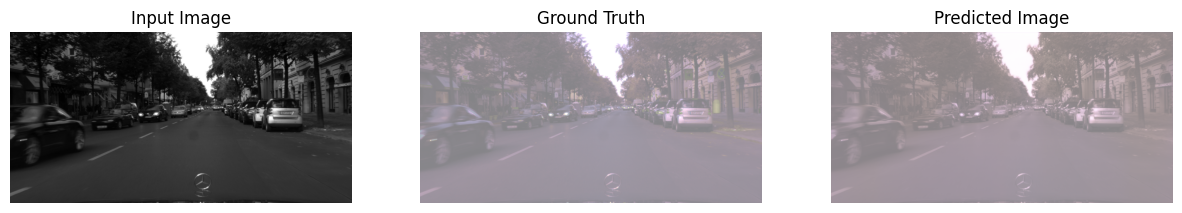

In [5]:
inputs, targets = next(iter(val_dataloader))
IDX = 3
generate_image(model, inputs[IDX], targets[IDX], 300, save=False)

In [16]:
from dataset import ImageDataset

my_dataset_df = get_image_paths_df(Path("inf_test"))

my_dataset = ImageDataset(my_dataset_df)

FileNotFoundError: [Errno 2] No such file or directory: 'inf_test/img_gray'

In [7]:
my_dataset[0][1]

tensor([[[0.1647, 0.1647, 0.1647,  ..., 0.2353, 0.2314, 0.2314],
         [0.1647, 0.1647, 0.1647,  ..., 0.2353, 0.2314, 0.2314],
         [0.1647, 0.1647, 0.1647,  ..., 0.2314, 0.2275, 0.2275],
         ...,
         [0.3451, 0.3451, 0.3529,  ..., 0.0941, 0.0941, 0.0941],
         [0.3451, 0.3490, 0.3529,  ..., 0.0941, 0.0941, 0.0941],
         [0.3451, 0.3490, 0.3529,  ..., 0.0941, 0.0941, 0.0941]],

        [[0.2510, 0.2510, 0.2510,  ..., 0.3373, 0.3333, 0.3333],
         [0.2510, 0.2510, 0.2510,  ..., 0.3373, 0.3333, 0.3333],
         [0.2510, 0.2510, 0.2510,  ..., 0.3333, 0.3294, 0.3294],
         ...,
         [0.4039, 0.4039, 0.4118,  ..., 0.1686, 0.1686, 0.1686],
         [0.4039, 0.4078, 0.4118,  ..., 0.1686, 0.1686, 0.1686],
         [0.4039, 0.4078, 0.4118,  ..., 0.1686, 0.1686, 0.1686]],

        [[0.3451, 0.3451, 0.3451,  ..., 0.2235, 0.2196, 0.2196],
         [0.3451, 0.3451, 0.3451,  ..., 0.2235, 0.2196, 0.2196],
         [0.3451, 0.3451, 0.3451,  ..., 0.2196, 0.2157, 0.

In [8]:
my_dataset[0][0].shape

torch.Size([3, 695, 1280])

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([A.Resize(1024, 795), ToTensorV2()])
img_rgb = my_dataset[0][1].permute(1, 2, 0).numpy()
img_gray = my_dataset[0][0][0].unsqueeze(0).permute(1, 2, 0).numpy()

rgb_resized = transform(image=img_rgb)["image"]
gray_resized = transform(image=img_gray)["image"]

torch.Size([1, 64, 512, 397])
torch.Size([1, 64, 256, 198])
torch.Size([1, 128, 128, 99])
torch.Size([1, 256, 64, 49])
torch.Size([1, 256, 32, 24])
torch.Size([1, 512, 16, 12])
AFTER BOTTLENECK: torch.Size([1, 512, 8, 6])
x: torch.Size([1, 512, 16, 12])     |     residual_x: torch.Size([1, 512, 16, 12])
x: torch.Size([1, 256, 32, 24])     |     residual_x: torch.Size([1, 256, 32, 24])
x: torch.Size([1, 256, 64, 48])     |     residual_x: torch.Size([1, 256, 64, 49])
PADDING: torch.Size([1, 256, 64, 49])
x: torch.Size([1, 128, 128, 98])     |     residual_x: torch.Size([1, 128, 128, 99])
PADDING: torch.Size([1, 128, 128, 99])
x: torch.Size([1, 64, 256, 198])     |     residual_x: torch.Size([1, 64, 256, 198])
x: torch.Size([1, 64, 512, 396])     |     residual_x: torch.Size([1, 64, 512, 397])
PADDING: torch.Size([1, 64, 512, 397])


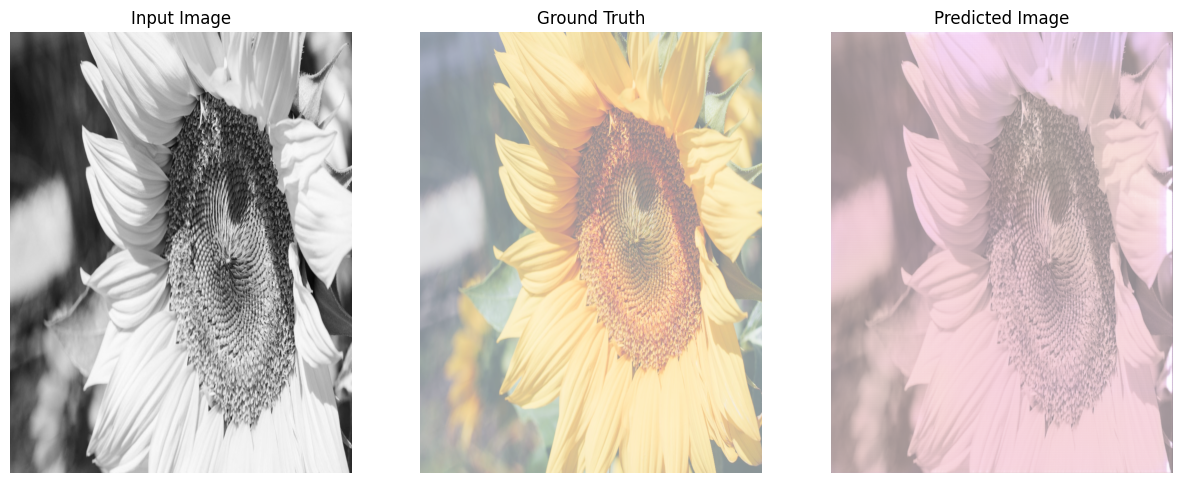

In [12]:
generate_image(
    model,
    gray_resized.to(device),
    rgb_resized.to(device),
    300,
    save=False,
)

In [47]:
rgb_resized.shape

torch.Size([3, 1024, 724])

In [11]:
gray_resized.device

device(type='cpu')

In [ ]:
import matplotlib.pyplot as plt


def ishow(
    img, cmap="viridis", title="", fig_size=(8, 6), colorbar=True, interpolation="none"
):
    "Function `ishow` displays an image in a new window."

    extent = (0, img.shape[1], img.shape[0], 0)
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(img, extent=extent, cmap=cmap, interpolation=interpolation)

    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        fig.colorbar(pcm, orientation="vertical")
    plt.show()

In [17]:
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

img_path = Path("inf_test/berlin_000518_000019_leftImg8bit.png")
input_img = pil_to_tensor(Image.open(img_path)) / 255


In [34]:
res = model(input_img.unsqueeze(0).to(device)).detach().cpu()[0]

img_np = res.permute(1, 2, 0).numpy()

torch.Size([1, 64, 256, 512])
torch.Size([1, 64, 128, 256])
torch.Size([1, 128, 64, 128])
torch.Size([1, 256, 32, 64])
torch.Size([1, 256, 16, 32])
torch.Size([1, 512, 8, 16])
AFTER BOTTLENECK: torch.Size([1, 512, 4, 8])
x: torch.Size([1, 512, 8, 16])     |     residual_x: torch.Size([1, 512, 8, 16])
x: torch.Size([1, 256, 16, 32])     |     residual_x: torch.Size([1, 256, 16, 32])
x: torch.Size([1, 256, 32, 64])     |     residual_x: torch.Size([1, 256, 32, 64])
x: torch.Size([1, 128, 64, 128])     |     residual_x: torch.Size([1, 128, 64, 128])
x: torch.Size([1, 64, 128, 256])     |     residual_x: torch.Size([1, 64, 128, 256])
x: torch.Size([1, 64, 256, 512])     |     residual_x: torch.Size([1, 64, 256, 512])


In [42]:
img_np.shape

(512, 1024, 3)

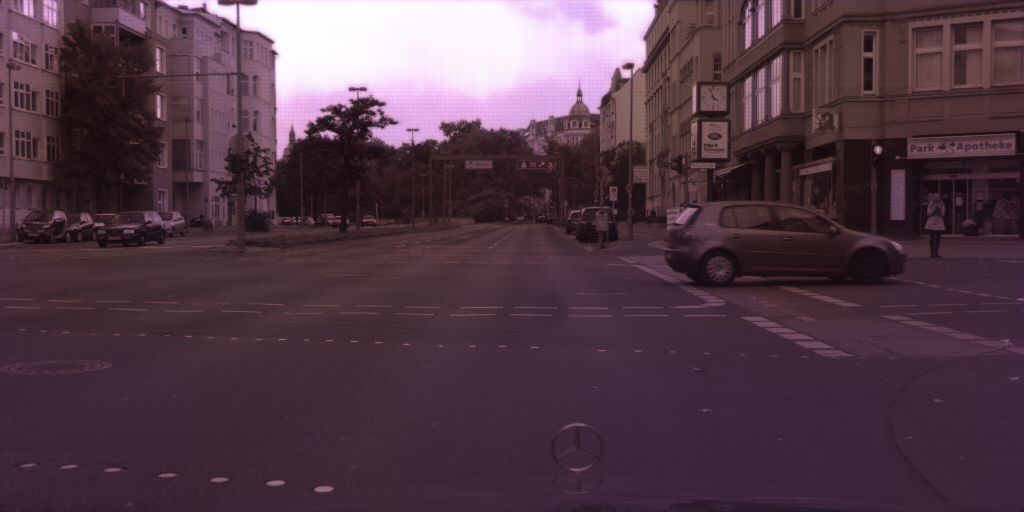

In [49]:
Image.fromarray((img_np * 255).astype(np.uint8), mode="RGB")

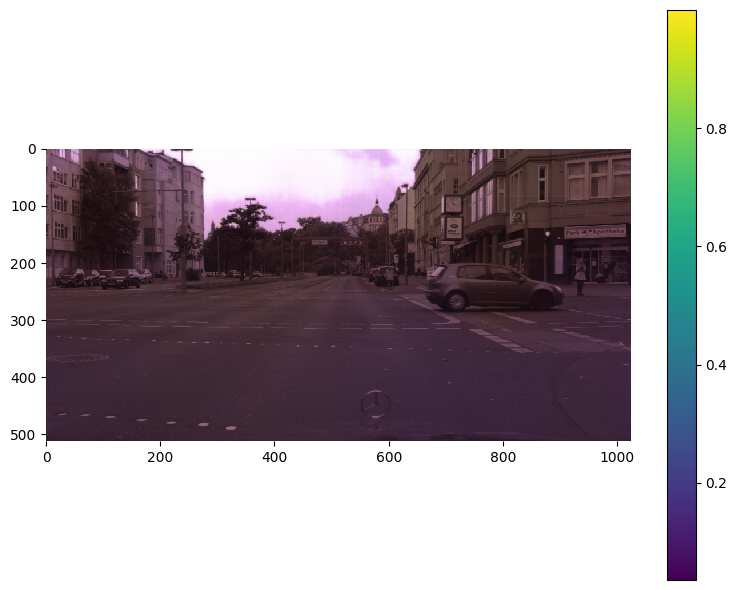

In [48]:
ishow(img_np)

In [ ]:
import cv2
import numpy as np

# Assuming img_np is your numpy array
img_scaled = (img_np * 255).astype(np.uint8)  # Ensure it's uint8
cv2.imshow("image", img_scaled)
cv2.waitKey(0)
cv2.destroyAllWindows()


error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [51]:
from training import draw_network_architecture

draw_network_architecture(model, torch.randn([1, 1, 1024, 512]))

torch.Size([1, 64, 512, 256])
torch.Size([1, 64, 256, 128])
torch.Size([1, 128, 128, 64])
torch.Size([1, 256, 64, 32])
torch.Size([1, 256, 32, 16])
torch.Size([1, 512, 16, 8])
AFTER BOTTLENECK: torch.Size([1, 512, 8, 4])
x: torch.Size([1, 512, 16, 8])     |     residual_x: torch.Size([1, 512, 16, 8])
x: torch.Size([1, 256, 32, 16])     |     residual_x: torch.Size([1, 256, 32, 16])
x: torch.Size([1, 256, 64, 32])     |     residual_x: torch.Size([1, 256, 64, 32])
x: torch.Size([1, 128, 128, 64])     |     residual_x: torch.Size([1, 128, 128, 64])
x: torch.Size([1, 64, 256, 128])     |     residual_x: torch.Size([1, 64, 256, 128])
x: torch.Size([1, 64, 512, 256])     |     residual_x: torch.Size([1, 64, 512, 256])


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [4]:
discriminator

Discriminator(
  (down1): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
from pathlib import Path

import torch
from torch import Tensor, nn


class Discriminator(nn.Module):
    def __init__(self, input_channels: int) -> None:
        super().__init__()
        # Ck = Convolution-BatchNorm-ReLU
        # discriminator: C64-C128-C256-C512 -> classification head (sigmoid)

        self.down1 = DownBlock(input_channels, 64, False)
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512, stride=1)

        self.last = nn.Conv2d(512, 1, kernel_size=(4, 4), stride=1, padding=1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)

        x = nn.functional.sigmoid(self.last(x))
        return x


class DownBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        batch_norm: bool = True,
        stride: int = 2,
    ) -> None:
        super().__init__()
        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(4, 4),
                stride=2,
                padding=1,
                bias=False,
            ),
        ]

        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        self.downsample = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.downsample(x)

In [ ]:
discriminator = Discriminator(3)
dummy_input = torch.randn(16, 3, 256, 256)  # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 15, 15])

In [10]:
discriminator

Discriminator(
  (down1): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (down2): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down3): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (down4): DownBlock(
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_